# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


##### 사내 서버 경로

In [1]:
import os
os.getcwd()
os.chdir('/root/data/highkh/cs231n/highkh/assignment1')

#### 아래 과정은 대부분 svm과 같은 방식

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.337147
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
*SVM때와 같은 이유임* 

CIFAR10의 class가 10개이고, 임의의 input이 해당 label과 맞아 떨어질 확률은 10% = 0.1

Cross-entropy에 대입하면 다른 것들은 0이 되어 사라지기 때문에 -log(0.1)만 남게 된다.


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

print "---------------------------no regularization------------------------------------------"
# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)
print "---------------------------regularization 100------------------------------------------"
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

---------------------------no regularization------------------------------------------
numerical: 0.322230	 analytic: 0.322230	 relative error: 2.399239e-08	 absolute error: 1.546212e-08
numerical: 1.327386	 analytic: 1.327386	 relative error: 2.242514e-08	 absolute error: 5.953364e-08
numerical: 0.123270	 analytic: 0.123270	 relative error: 1.334339e-07	 absolute error: 3.289676e-08
numerical: 0.601613	 analytic: 0.601613	 relative error: 1.267824e-07	 absolute error: 1.525479e-07
numerical: 3.812089	 analytic: 3.812089	 relative error: 1.869542e-08	 absolute error: 1.425372e-07
numerical: -3.666321	 analytic: -3.666321	 relative error: 2.042089e-08	 absolute error: 1.497391e-07
numerical: -0.161897	 analytic: -0.161897	 relative error: 3.168185e-08	 absolute error: 1.025840e-08
numerical: -1.936355	 analytic: -1.936355	 relative error: 9.413570e-09	 absolute error: 3.645602e-08
numerical: 2.970002	 analytic: 2.970001	 relative error: 2.986707e-08	 absolute error: 1.774105e-07
numeric

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.337147e+00 computed in 0.093375s
vectorized loss: 2.337147e+00 computed in 0.007715s
Loss difference: 0.000000
Gradient difference: 0.000000


#### Naive vs. Vec'ed loss and gradient : Vec version이 약 12배 빠름

In [10]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

learning_rates = [5e-7, 2e-6]
regularization_strengths = [1e4, 1e5]

rand_num = 16

rand_learning_rates = []
rand_regularization_strengths = []

for i in xrange(rand_num):
    rand_learning_rates.append(random.uniform(learning_rates[0], learning_rates[1]))
    rand_regularization_strengths.append(random.uniform(regularization_strengths[0], regularization_strengths[1]))
random.shuffle(rand_learning_rates)
random.shuffle(rand_regularization_strengths)
print 'picked lr = ', rand_learning_rates
print 'picked rg = ', rand_regularization_strengths

#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
rand_iter = 1
for lr, rg in zip(rand_learning_rates, rand_regularization_strengths):
    
    print 'rand iter = %d / %d' % (rand_iter, rand_num)
    bh_softmax = Softmax()
    loss_hist = bh_softmax.train(X_train, y_train, learning_rate=lr, reg=rg,
                                 num_iters=2000, verbose=True)
    
    y_train_pred = bh_softmax.predict(X_train)
    y_val_pred = bh_softmax.predict(X_val)
    train_acc = np.mean(y_train == y_train_pred)
    val_acc = np.mean(y_val == y_val_pred)
    results[(lr, rg)] = (train_acc, val_acc)
        
    if val_acc > best_val:
        best_val = val_acc
        best_softmax = bh_softmax
    rand_iter += 1

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

picked lr =  [1.7347370800368192e-06, 1.5691069068766454e-06, 1.4440663900744285e-06, 8.594210540965473e-07, 1.6314517566864104e-06, 1.5622617677697621e-06, 1.5237440112205187e-06, 1.1906714412665604e-06, 1.9402846772061044e-06, 1.400520088417334e-06, 1.1159720873674442e-06, 7.153829000717907e-07, 9.519631278825142e-07, 1.1013748828976998e-06, 6.846787181507406e-07, 1.4766170760701158e-06]
picked rg =  [47023.14222644211, 13766.118671426317, 19862.053908838265, 19920.506655690562, 83999.4163335554, 57311.875967874395, 58554.27173885473, 54384.36674613735, 37488.683691029844, 22102.06466368645, 15670.651615243587, 87464.87741970866, 35528.35617509368, 91786.13781533593, 37804.79727187581, 46077.33101150072]
rand iter = 1 / 16
-----------learning_rate : 1.734737e-06	 reg : 4.702314e+04----------
iteration 0 / 2000: loss 736.920855
iteration 100 / 2000: loss 2.100372
iteration 200 / 2000: loss 2.101546
iteration 300 / 2000: loss 2.127126
iteration 400 / 2000: loss 2.138708
iteration 500 /

#### valid acc = 37.5% > 35%
#### learning rate와 regularization strength를 축에 상관 없이 16개 random choose하였음

In [11]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.360000


#### SVM과 유사한 형태의 weight image가 나왔음

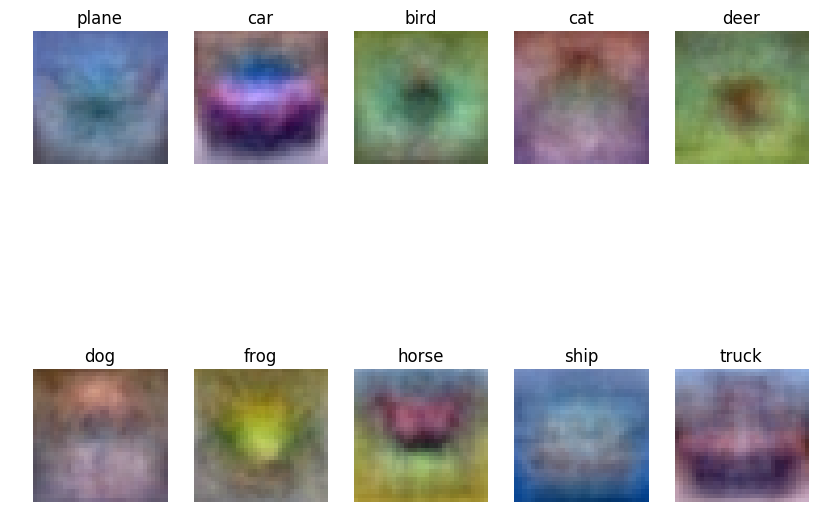

In [12]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])